<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/breaker_ranking_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/capstone

/content/drive/MyDrive/Github/capstone


In [3]:
%ls

brace/  datasets/  images/  __pycache__/  README.md  utilities/


In [4]:
!pip install skelo

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone')

In [6]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
import joblib
from sklearn.preprocessing import LabelEncoder
from skelo.model.elo import EloEstimator
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skelo.model.glicko2 import Glicko2Estimator
# import glicko2

In [9]:
#load files
trivium= pd.read_csv('/content/drive/MyDrive/Github/capstone/datasets/trivium_scorecard.csv')
webscraping = pd.read_excel('/content/drive/MyDrive/Github/capstone/datasets/Webscraping.xlsx', sheet_name=None)
webscraping.keys()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


dict_keys(['Events and8', 'Events', 'Events WDSF', 'Battles Trivium', 'Battles and8 Threefold', 'Battles and8 Single Slider', 'Battles and8 Round by Round', 'Battles and8 Traditional', 'Research Questions', 'Notes', 'Notes Columns'])

In [ ]:
#Load battle winners
#threefold
threefold = webscraping['Battles and8 Threefold']
threefold.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category', 'breaker 1': 'breaker 1 (red)', 'breaker 2': 'breaker 2 (blue)'}, inplace=True)
threefold[['Event', 'Category']] = threefold[['Event', 'Category']].fillna(method='ffill')
#Trivium
trivium=webscraping['Battles Trivium']
trivium.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
trivium[['Event', 'Category']]= trivium[['Event', 'Category']].fillna(method='ffill')
#traditional
traditional = webscraping['Battles and8 Traditional']
traditional.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
traditional[['Event', 'Category']] = traditional[['Event', 'Category']].fillna(method='ffill')

In [ ]:
tr=traditional[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
th=threefold[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
tv=trivium[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()

dataframes = [('traditional', tr), ('threefold', th), ('trivium', tv)]

# Create an empty list to store modified dataframes
appended_dfs = []

# Iterate to create a combined dataframe
for name, dframe in dataframes:
    dframe['Original_DF'] = name
    dframe['Battle_ID'] = dframe.index
    appended_dfs.append(dframe)
appendedBattles = pd.concat(appended_dfs, ignore_index=True)


In [ ]:
eventsAnd8=webscraping['Events and8'][1:].copy()
new_header= eventsAnd8.iloc[0]
eventsAnd8=eventsAnd8.drop(1)
eventsAnd8.columns = new_header
eventsAnd8.rename(columns={'Name':'Event'}, inplace=True)
eventsAnd8.drop_duplicates(subset=['Event'], inplace=True)

eventsWDSF = webscraping['Events WDSF'][1:].copy()
new_header = eventsWDSF.iloc[0]
eventsWDSF = eventsWDSF.drop(1)
eventsWDSF.columns = new_header
eventsWDSF.rename(columns={'Name': 'Event'}, inplace=True)
eventsWDSF.drop_duplicates(subset=['Event'], inplace=True)

Events = webscraping['Events'][1:].copy()
new_header = Events.iloc[0]
Events = Events.drop(1)
Events.columns = new_header
Events.rename(columns={'Name':'Event'}, inplace=True)
Events.drop_duplicates(subset=['Event'], inplace=True)

combined_events = pd.concat([eventsAnd8, eventsWDSF, Events], ignore_index=True)

In [ ]:
#add battle date
appendedBattles=pd.merge(appendedBattles, combined_events[['Date', 'Event']], on='Event', how='left')
appendedBattles['loser'] = np.where(appendedBattles['winner'] == appendedBattles['breaker 1 (red)'], appendedBattles['breaker 2 (blue)'], appendedBattles['breaker 1 (red)'])
appendedBattles[['winner', 'loser']]=appendedBattles[['winner', 'loser']].astype(str)
battlesNotide=appendedBattles[appendedBattles['winner']!='Tie'].copy()

In [ ]:
#Format battles data into format reconized by skelo, instead of distinguishing between winners and losers, it labels one player as "player1" and the other as "player2"
#and assigns a binary label (1 for player1 winning and 0 for player2 winning).
def load_data(df):
    df["Date"] = pd.to_datetime(df['Date'])
    order_mask = (df["winner"] < df["loser"])
    df["p1"] = ""
    df["p2"] = ""
    df["label"] = 1
    df.loc[order_mask, "p1"] = df.loc[order_mask, "winner"]
    df.loc[~order_mask, "p1"] = df.loc[~order_mask, "loser"]
    df.loc[order_mask, "p2"] = df.loc[order_mask, "loser"]
    df.loc[~order_mask, "p2"] = df.loc[~order_mask, "winner"]
    df.loc[~order_mask, "label"] = 0

    return df

In [ ]:
battlesNotide= load_data(battlesNotide)

In [ ]:
boys = battlesNotide[(battlesNotide['Category'].str.contains('Boy')) | (battlesNotide['Category'].str.contains('Men'))]
girls= battlesNotide[(battlesNotide['Category'].str.contains('Girl')) | (battlesNotide['Category'].str.contains('Women'))]
others = battlesNotide[~battlesNotide.index.isin(boys.index) & ~battlesNotide.index.isin(girls.index)]

boys.shape[0], girls.shape[0],others.shape[0], battlesNotide.shape[0]== (boys.shape[0]+ girls.shape[0]+others.shape[0])

(1386, 851, 336, True)

In [ ]:
def fit_model(X):
    X_subset = X[['Date', 'p1', 'p2', 'label']]
    model = EloEstimator(
        key1_field="p1",
        key2_field="p2",
        timestamp_field="Date",
        initial_time=min(X['Date'])
    )
    fitted_model = model.fit(X_subset, X_subset["label"])

    return fitted_model

In [ ]:
def plot_top_ratings(ax, ratings_frame, title):
    ts_est = ratings_frame.pivot_table(index='valid_from', columns='key', values='rating').ffill()
    idx = ts_est.iloc[-1].sort_values().index[-5:]
    ts_est.loc[:, idx].plot(ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Rating')
    ax.set_title(f'Top 5 Ratings Over Time - {title}')
    ax.legend(title='Player')
    ax.grid(True)

In [ ]:
X_boy= boys[['Date', 'p1', 'p2', 'label']]
X_girl= girls[['Date', 'p1', 'p2', 'label']]
X_other= others[['Date', 'p1', 'p2', 'label']]

In [ ]:
g_model=fit_model(X_girl)
b_model=fit_model(X_boy)
o_model=fit_model(X_other)

In [ ]:
boy_elo_rank= b_model.rating_model.to_frame()
girl_elo_rank=g_model.rating_model.to_frame()
other_elo_rank=o_model.rating_model.to_frame()

In [ ]:
boy_elo_current=boy_elo_rank[(boy_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
boy_top10=boy_elo_current[(boy_elo_rank['valid_from']>= '2023-01-01')].nlargest(10, 'rating')
girl_elo_current = girl_elo_rank[(girl_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
girl_top10 = girl_elo_current[(girl_elo_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'rating')
other_elo_current = other_elo_rank[(other_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
other_top10 = other_elo_current[(other_elo_current['valid_from']>= '2023-01-01')].nlargest(10, 'rating')

<ipython-input-97-f6b1ed5a7d06>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  boy_top10=boy_elo_current[(boy_elo_rank['valid_from']>= '2023-01-01')].nlargest(10, 'rating')
<ipython-input-97-f6b1ed5a7d06>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  girl_top10 = girl_elo_current[(girl_elo_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'rating')


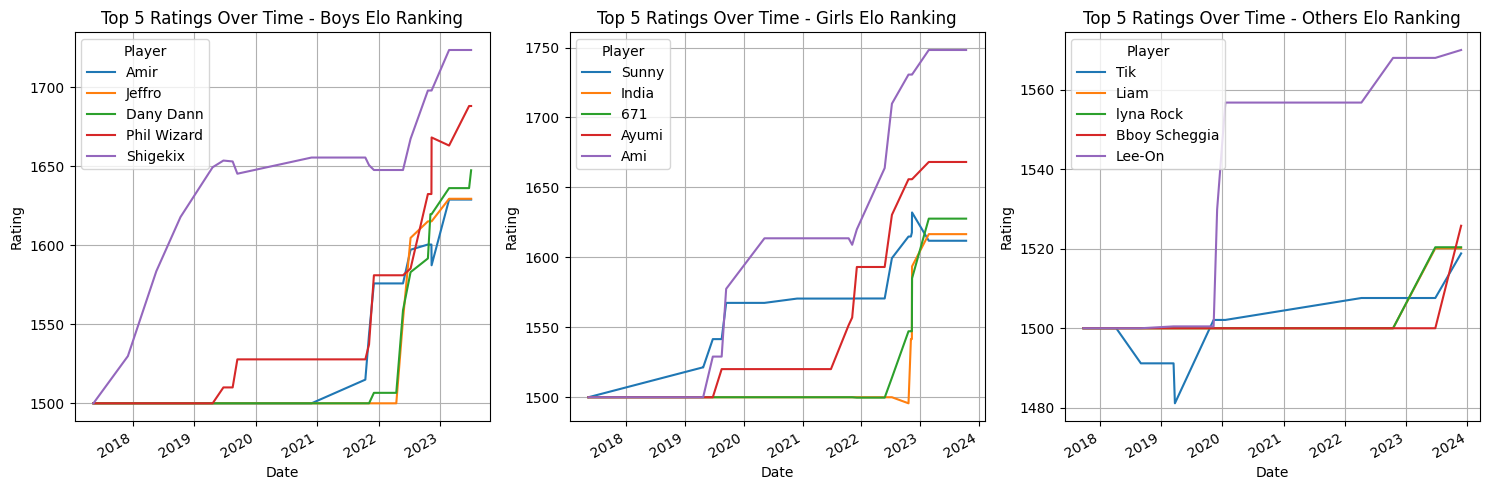

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each model's top ratings horizontally
plot_top_ratings(axes[0], boy_elo_rank[boy_elo_rank['key'].isin(boy_top10['key'].to_list())], 'Boys Elo Ranking')
plot_top_ratings(axes[1], girl_elo_rank[girl_elo_rank['key'].isin(girl_top10['key'].to_list())], 'Girls Elo Ranking')
plot_top_ratings(axes[2], other_elo_rank[other_elo_rank['key'].isin(other_top10['key'].to_list())], 'Others Elo Ranking')
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(X_girl["label"], g_model.predict(X_girl)))

              precision    recall  f1-score   support

           0       0.57      0.71      0.63       382
           1       0.70      0.56      0.62       469

    accuracy                           0.63       851
   macro avg       0.63      0.63      0.63       851
weighted avg       0.64      0.63      0.63       851



In [ ]:
print(classification_report(X_boy["label"], b_model.predict(X_boy)))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       694
           1       0.62      0.37      0.47       692

    accuracy                           0.57      1386
   macro avg       0.59      0.57      0.56      1386
weighted avg       0.59      0.57      0.56      1386



In [ ]:
print(classification_report(X_other["label"], o_model.predict(X_other)))

              precision    recall  f1-score   support

           0       0.52      0.85      0.65       176
           1       0.47      0.15      0.23       160

    accuracy                           0.51       336
   macro avg       0.50      0.50      0.44       336
weighted avg       0.50      0.51      0.45       336



Glicko Rating

In [ ]:
def fit_model_G(X):
    # Extracting required columns
    X_subset = X[['Date', 'p1', 'p2', 'label']]

    # Create an instance of the EloEstimator model
    model= Glicko2Estimator(
            key1_field="p1",
            key2_field="p2",
            timestamp_field="Date",
            initial_time=min(appendedBattles['Date']))

    # Fit the model
    fitted_model = model.fit(X_subset, X_subset["label"])

    return fitted_model

In [ ]:
g_model_glicko=fit_model_G(X_girl)
b_model_glicko=fit_model_G(X_boy)
o_model_glicko=fit_model_G(X_other)

In [ ]:
boy_glicko_rank= b_model_glicko.rating_model.to_frame()
girl_glicko_rank=g_model_glicko.rating_model.to_frame()
other_glicko_rank=o_model_glicko.rating_model.to_frame()

In [ ]:
boy_glicko_rank[['ranking', 'deviation', 'volatility']] = boy_glicko_rank['rating'].tolist()
girl_glicko_rank[['ranking', 'deviation', 'volatility']] = girl_glicko_rank['rating'].tolist()
other_glicko_rank[['ranking', 'deviation', 'volatility']] = other_glicko_rank['rating'].tolist()

In [ ]:
boy_glicko_current = boy_glicko_rank[(boy_glicko_rank['valid_to'].isnull())].sort_values(by='ranking', ascending=False)
boy_top10_glicko = boy_glicko_current[(boy_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')
girl_glicko_current = girl_glicko_rank[(girl_glicko_rank['valid_to'].isnull())].sort_values(by='ranking', ascending=False)
girl_top10_glicko = girl_glicko_current[(girl_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')
other_glicko_current = other_glicko_rank[(other_glicko_rank['valid_to'].isnull())].sort_values(by='ranking', ascending=False)
other_top10_glicko = other_glicko_current[(other_glicko_current['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')


<ipython-input-106-0581bcdd54d3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  boy_top10_glicko = boy_glicko_current[(boy_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')
<ipython-input-106-0581bcdd54d3>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  girl_top10_glicko = girl_glicko_current[(girl_glicko_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'ranking')


In [ ]:
def plot_top_ratings_glicko(ax, ratings_frame, title):
    ts_est = ratings_frame.pivot_table(index='valid_from', columns='key', values='ranking').ffill()
    idx = ts_est.iloc[-1].sort_values().index[-5:]
    ts_est.loc[:, idx].plot(ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Ranking')
    ax.set_title(f'Top 5 Ratings Over Time - {title}')
    ax.legend(title='Player')
    ax.grid(True)

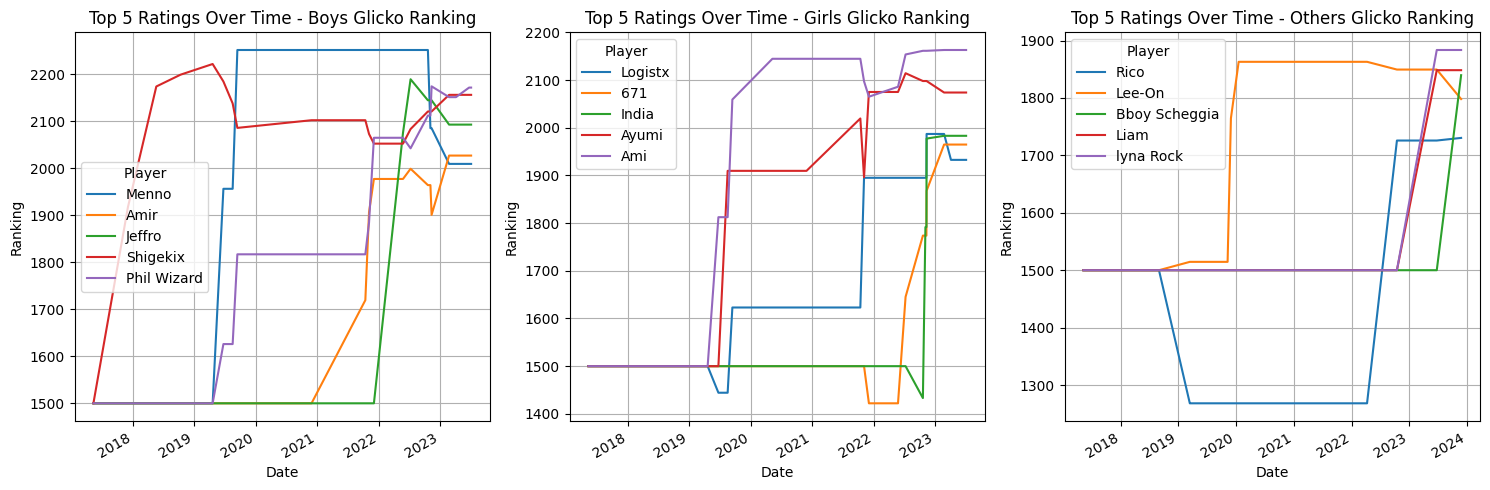

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each model's top ratings horizontally
plot_top_ratings_glicko(axes[0], boy_glicko_rank[boy_glicko_rank['key'].isin(boy_top10_glicko['key'].to_list())], 'Boys Glicko Ranking')
plot_top_ratings_glicko(axes[1], girl_glicko_rank[girl_glicko_rank['key'].isin(girl_top10_glicko['key'].to_list())], 'Girls Glicko Ranking')
plot_top_ratings_glicko(axes[2], other_glicko_rank[other_glicko_rank['key'].isin(other_top10_glicko['key'].to_list())], 'Others Glicko Ranking')
plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(X_girl["label"], g_model_glicko.predict(X_girl)))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64       382
           1       0.71      0.56      0.63       469

    accuracy                           0.63       851
   macro avg       0.64      0.64      0.63       851
weighted avg       0.65      0.63      0.63       851



In [ ]:
print(classification_report(X_boy["label"], b_model_glicko.predict(X_boy)))

              precision    recall  f1-score   support

           0       0.56      0.79      0.66       694
           1       0.64      0.39      0.48       692

    accuracy                           0.59      1386
   macro avg       0.60      0.59      0.57      1386
weighted avg       0.60      0.59      0.57      1386



In [ ]:
print(classification_report(X_other["label"], o_model_glicko.predict(X_other)))

              precision    recall  f1-score   support

           0       0.52      0.82      0.64       176
           1       0.45      0.16      0.23       160

    accuracy                           0.51       336
   macro avg       0.48      0.49      0.43       336
weighted avg       0.48      0.51      0.44       336



In [ ]:
boy_glicko_rank[boy_glicko_rank['key'].isin(boy_top10_glicko['key'].to_list())]
girl_glicko_rank[girl_glicko_rank['key'].isin(girl_top10_glicko['key'].to_list())]
other_glicko_rank[other_glicko_rank['key'].isin(other_top10_glicko['key'].to_list())]

,key,rating,valid_from,valid_to,ranking,deviation,volatility
1455,Wing,"(1500.0, 350.0, 0.06)",2017-05-11,2023-02-24,1500.000000,350.000000,0.060000
1456,Wing,"(1477.8577967457343, 328.92745406575733, 0.059...",2023-02-24,2023-02-24,1477.857797,328.927454,0.060000
1457,Wing,"(1460.0069253641457, 313.13622888727986, 0.059...",2023-02-24,2023-02-24,1460.006925,313.136229,0.059999
1458,Wing,"(1556.8066830501023, 263.05829776754126, 0.059...",2023-02-24,2023-02-24,1556.806683,263.058298,0.059998
1459,Wing,"(1836.5525336741837, 239.28582725899258, 0.060...",2023-02-24,2023-04-06,1836.552534,239.285827,0.060007
...,...,...,...,...,...,...,...
3386,Gravity,"(1986.172584890036, 113.20445241687828, 0.0599...",2023-02-24,2023-02-24,1986.172585,113.204452,0.059992
3387,Gravity,"(1992.9940780799016, 111.77684880794428, 0.059...",2023-02-24,2023-02-24,1992.994078,111.776849,0.059991
3388,Gravity,"(1973.060821119167, 107.86014397489156, 0.0599...",2023-02-24,2023-02-24,1973.060821,107.860144,0.059991
3389,Gravity,"(1978.4271212737885, 106.91449140468647, 0.059...",2023-02-24,2023-02-24,1978.427121,106.914491,0.059990


In [ ]:
# Filter the DataFrames based on 'key' being in their respective top10 lists
filtered_boy = boy_glicko_rank[boy_glicko_rank['key'].isin(boy_top10_glicko['key'].to_list())].copy()
filtered_girl = girl_glicko_rank[girl_glicko_rank['key'].isin(girl_top10_glicko['key'].to_list())].copy()
filtered_other = other_glicko_rank[other_glicko_rank['key'].isin(other_top10_glicko['key'].to_list())].copy()

# Add a new column to each DataFrame to identify its original source
filtered_boy['source'] = 'boy'
filtered_girl['source'] = 'girl'
filtered_other['source'] = 'other'

# Concatenate the three DataFrames into one
combined_glicko = pd.concat([filtered_boy, filtered_girl, filtered_other], ignore_index=True)


In [ ]:
pd.DataFrame(data={'Elo_boys':boy_top10['key'].to_numpy(), 'Glicko_boys': boy_top10_glicko['key'].to_numpy(),
                   'Elo_girls': girl_top10['key'].to_numpy(), 'Glicko_girls': girl_top10_glicko['key'].to_numpy(),
                   'Elo_Other':other_top10['key'].to_numpy(), 'Glicko_other': other_top10_glicko['key'].to_numpy() })

,Elo_boys,Glicko_boys,Elo_girls,Glicko_girls,Elo_Other,Glicko_other
0,Shigekix,Phil Wizard,Ami,Ami,Lee-On,lyna Rock
1,Phil Wizard,Shigekix,Ayumi,Ayumi,Bboy Scheggia,Bboy Scheggia
2,Amir,Jeffro,671,671,lyna Rock,Liam
3,Dany Dann,Amir,India,India,Liam,Lee-On
4,Jeffro,Wing,Sunny,Logistx,Tik,Rico
5,Kuzya,Menno,Alessandrina,Sunny,Rico,Jaron
6,Gravity,Kuzya,Anti,Kimie,Marox,Kid Kong
7,Lee,Gravity,Kimie,Riko,Jaron,Marox
8,Menno,Lee,Ayane,koharu,Sean,Tik
9,Lil Zoo,Dany Dann,Jilou,Jesly,Ryan King,Sean


Top 10 breakers analysis.

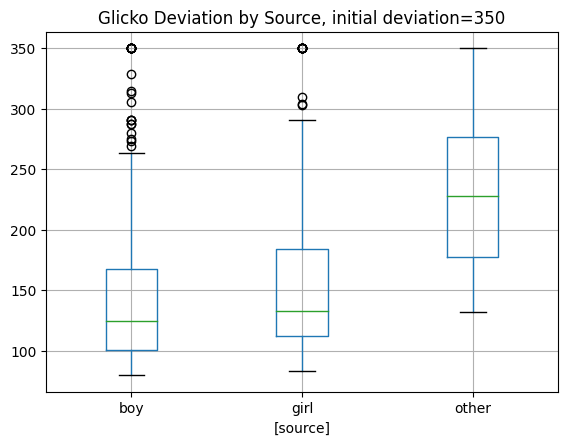

In [ ]:
combined_glicko[['source', 'deviation']].boxplot(by='source')
# Add a title to the plot
plt.title('Glicko Deviation by Source, initial deviation=350')
plt.suptitle('')

# Show the plot
plt.show()

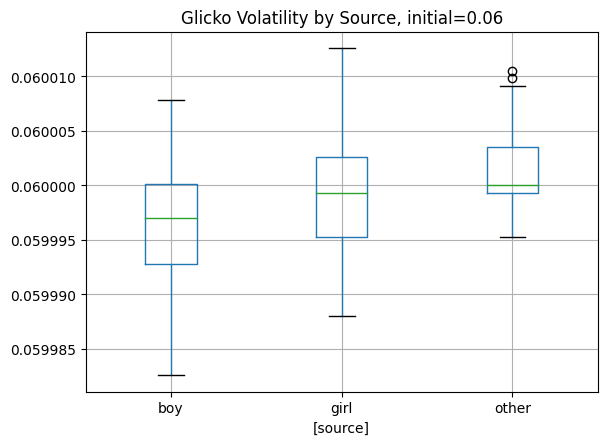

In [ ]:
combined_glicko[['source', 'volatility']].boxplot(by='source')
# Add a title to the plot
plt.title('Glicko Volatility by Source, initial=0.06')
plt.suptitle('')

# Show the plot
plt.show()

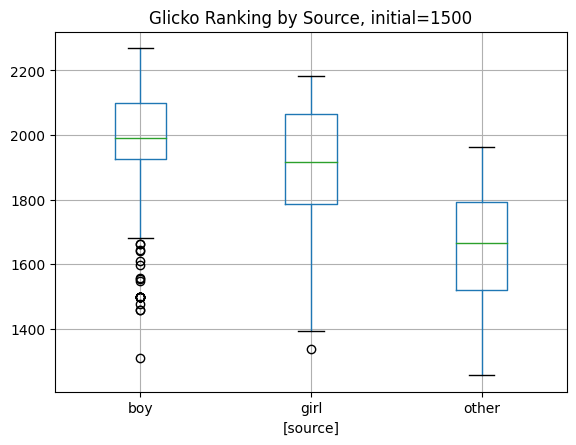

In [ ]:
combined_glicko[['source', 'ranking']].boxplot(by='source')
# Add a title to the plot
plt.title('Glicko Ranking by Source, initial=1500')
plt.suptitle('')

# Show the plot
plt.show()

In [ ]:
combined_glicko.groupby(by='source').agg({'key': 'count', 'ranking': np.mean, 'deviation': np.mean, 'volatility': np.mean})

,key,ranking,deviation,volatility
source,,,,
boy,324,1980.105413,147.055494,0.059996
girl,242,1891.970890,157.464825,0.059999
other,69,1662.587287,233.225971,0.060001
